In [211]:
! pip install -q 'gwosc==0.5.4'
! pip install pycbc

**This assigment was created using the recource Gravitational Wave Open Data Workshop by Ligo Virgo** [WorkShop](https://colab.research.google.com/drive/1YWGP_N6XJQO-ybaRZb5BoFb1puLgv8da#scrollTo=NdWbjO0vKOz3)


**Challenge 1, Assignment set 1**  
Identify a loud binary black hole signal in white, Gaussian noise.  
● Use the data file "challenge1.gwf". The channel name is
"H1:CHALLENGE1".  *italicized text*
● The data are white, Gaussian noise containing a simulated BBH signal.
1. Load the data into memory. What are the sampling rate and duration of the data?
2. Plot the data in the time-domain.
3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.
4. What is the time of the merger?

Step 1: Importing the data file and installing the appropriate packages

In [214]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

In [215]:
# -- for gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt


1. Extracting the Sampling rate in Hz and the duartion of the data

In [217]:

# Load the data
data = TimeSeries.read('challenge1.gwf', channel='H1:CHALLENGE1')

# Determine the sampling rate and duration
sampling_rate = data.sample_rate.value
duration = data.duration.value

print("Sampling Rate:", sampling_rate, "Hz")
print("Duration:", duration, "seconds")


Sampling Rate: 4096.0 Hz
Duration: 128.0 seconds


2. Plotting the data in the time domain
Details:
The x axis **time** represents the time during which the gravitational wave was observed in seconds
The y axis **strain** represents the change in length caused by the passing gravitational wave and is dimensionless.

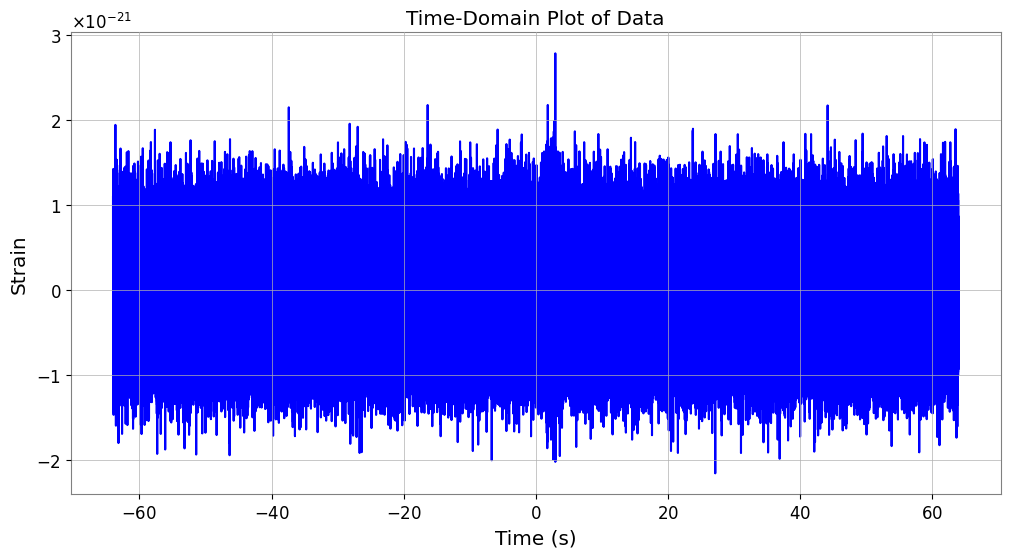

In [218]:
# 2. Plot the data in the time-domain
plt.figure(figsize=(12, 6))
plt.plot(data.times, data, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Plot of Data')
plt.grid(True)
plt.show()

3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.

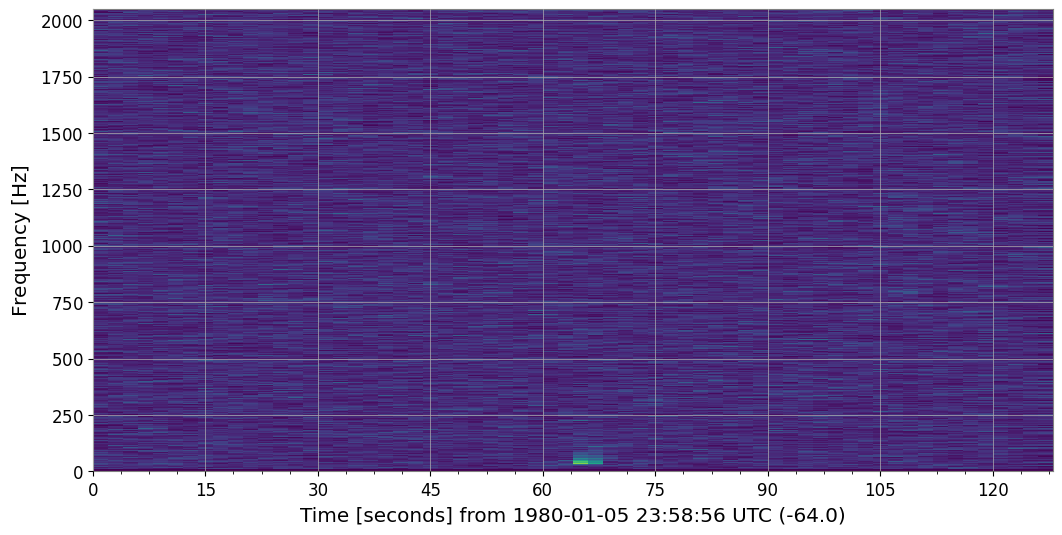

In [222]:
specgram = data.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

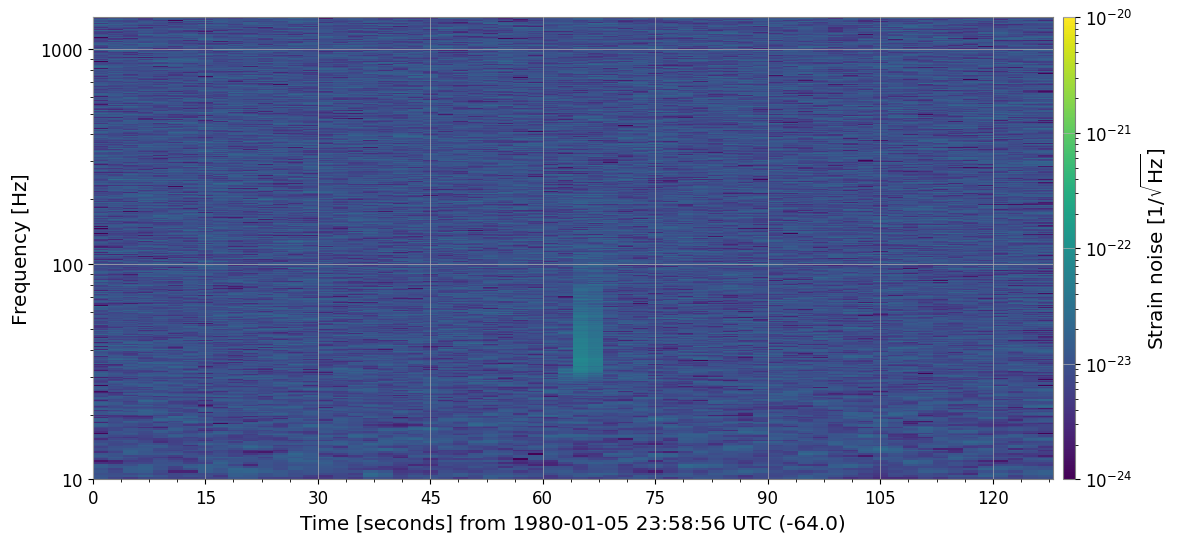

In [223]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot

Plotting a Q stransform for the data

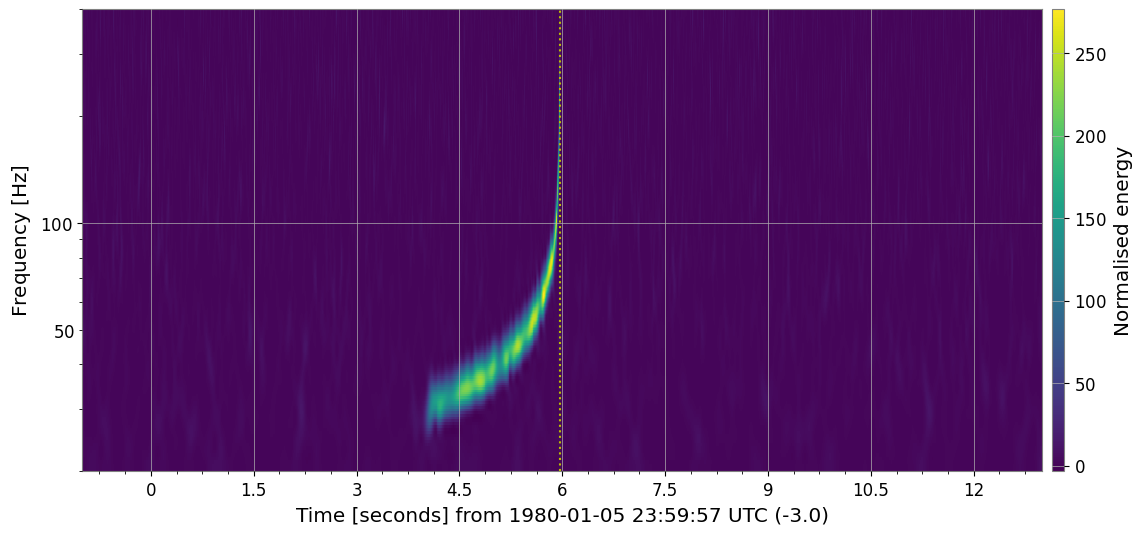

In [229]:
hq = data.q_transform(frange=(20, 400), qrange=(10, 15), outseg=(-4,10))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
t_est=2.97
plt.axvline(x=t_est, color='y', linestyle=':')
ax.colorbar(label="Normalised energy")

4. What is the time of the merger?
Using the guidence line of the g transform we can approximate the time of merger to be at around 2.97seconds



**Challenge 2, Assignment set 1**
Signal in colored, Gaussian noise.  
● Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"  
● The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.  
1. What is the approximative time of the merger? (Hint: a plot of the q-transform
could help)
2. Generate a time-domain template waveform using approximate
"SEOBNRv4_opt". with the same parameters as above. Plot this waveform.
3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging
from 20 Hz up to the Nyquist frequency.
4. Use the template waveform and PSD to calculate the SNR time series. Plot the
SNR time-series.
5. What is the matched filter SNR of the signal?

Importing the data:

In [65]:
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

In [67]:

# Determining the sampling rate and duration
sampling_rate2 = gwpy_strain.sample_rate.value
duration2 = gwpy_strain.duration.value

print("Sampling Rate:", sampling_rate, "Hz")
print("Duration:", duration, "seconds")


Sampling Rate: 4096.0 Hz
Duration: 128.0 seconds


Creating a q tranform graph of the data from challenge 2

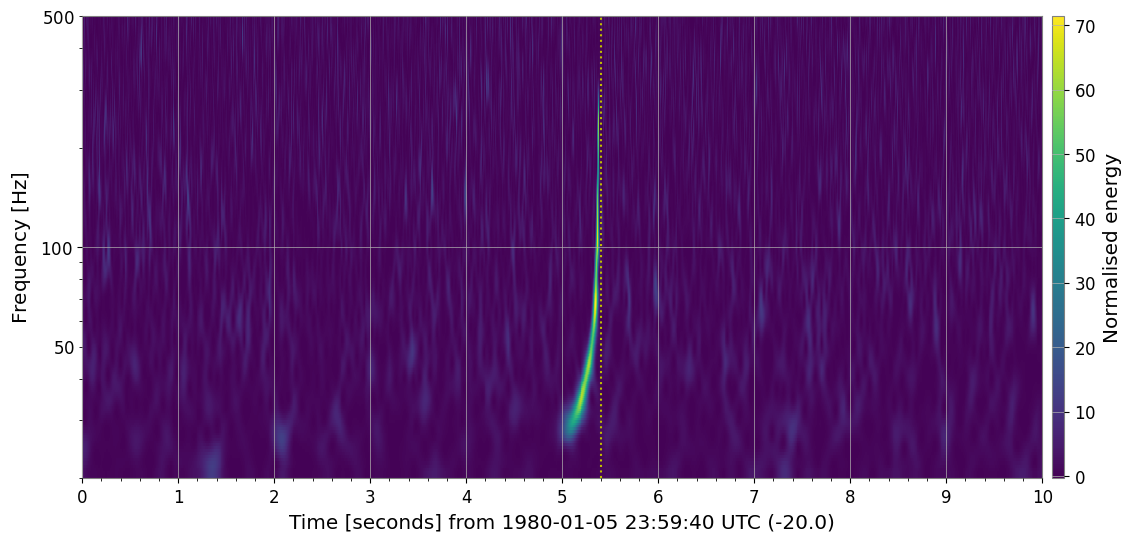

In [233]:
hq = gwpy_strain.q_transform(frange=(20, 500), qrange=(10, 15), outseg=(-20,-10))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
t_est=-14.6
plt.axvline(x=t_est, color='y', linestyle=':')
ax.colorbar(label="Normalised energy")

Using the same method as in challenge one we can approximate that the event happened around -14.6 seconds

2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.



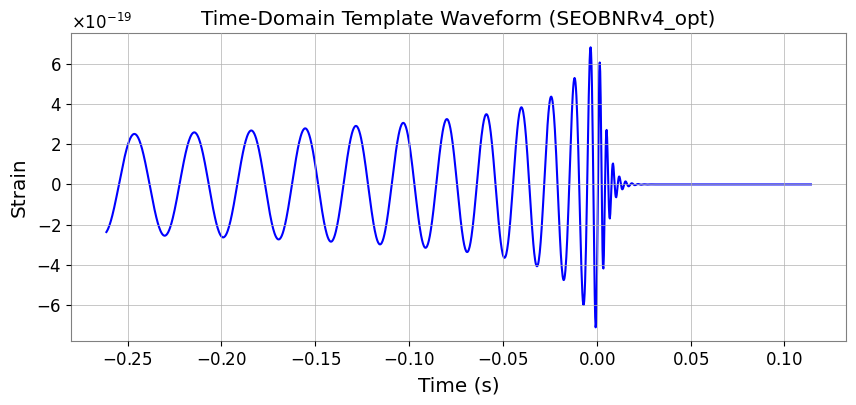

In [60]:

from pycbc.waveform import get_td_waveform

# Parameters
mass1 = 30  # Solar masses
mass2 = 30  # Solar masses
spin1z = 0  # Dimensionless spin (z-component)

# Generate time-domain template waveform
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=mass1,
                         mass2=mass2,
                         spin1z=spin1z,
                         delta_t=1.0/4096,
                         f_lower=30)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(hp.sample_times, hp, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Template Waveform (SEOBNRv4_opt)')
plt.grid(True)
plt.show()

3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging
from 20 Hz up to the Nyquist frequency.

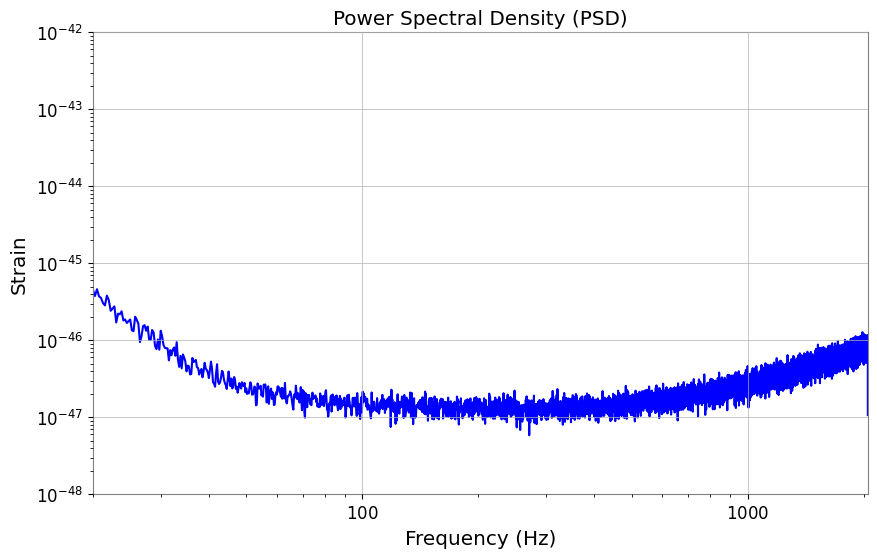

In [234]:
import numpy as np
nyqf=sampling_rate2/2
# Calculate the PSD
psd = gwpy_strain.psd(fftlength=4)

# Plot the PSD on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(psd.frequencies.value, psd.value, color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('Power Spectral Density (PSD)')
plt.xlim(20, nyqf)
plt.ylim(1e-48,1e-42)
plt.show()

4. Use the template waveform and PSD to calculate the SNR time series.

---

Using data conditioning to supress low frequency behaviour and dynamic range that can introduce numerical artifacts


In [156]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = pycbc_strain.crop(2, 2)
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)


Applying the cyclic time shift is preparing template waveform (hp) to be in the correct alignment with the data (conditioned). When performing matched filtering, the code is comparing the template and data properly

In [83]:
from pycbc.waveform import get_td_waveform
import pylab

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

In this step, we calculate the signal-to-noise time series for our template, ensuring we handle filter corruption and wraparound issues by truncating the output. We also consider the template length and 1/PSD for accurate calculations.

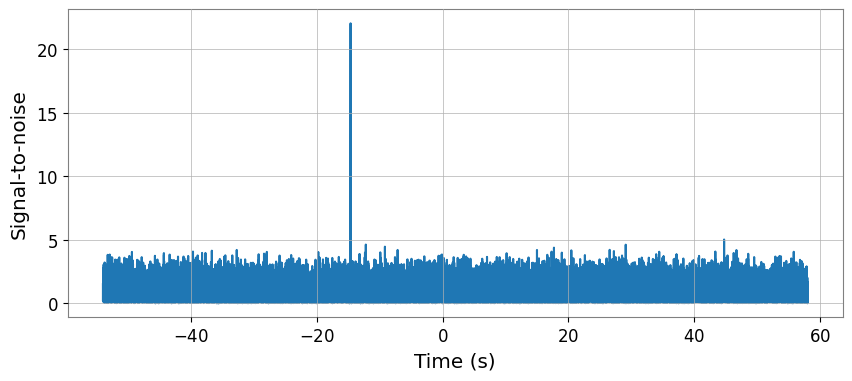

We found a signal at -14.6328125s with SNR 22.055412799223898


In [84]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

**5.What is the matched filter SNR of the signal?**

In [92]:
print("The matched filter SNR is:", abs(snrp))

The matched filter SNR is: 22.055412799223898


**3. Detector Noise**

1. Load the data of the LIGO Hanford detector from [2]. Plot the noise
power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW.  

In [94]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2024-02-25 15:22:04--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  43.9MB/s    in 1.3s    

2024-02-25 15:22:06 (43.9 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2024-02-25 15:22:06--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  45.3MB/s    in 1.3s    

20


This code snippet loads a noise time series from a file, creates a PyCBC TimeSeries object, and then plots the data. It provides a visual representation of the noise data over time, helping to understand its characteristics.

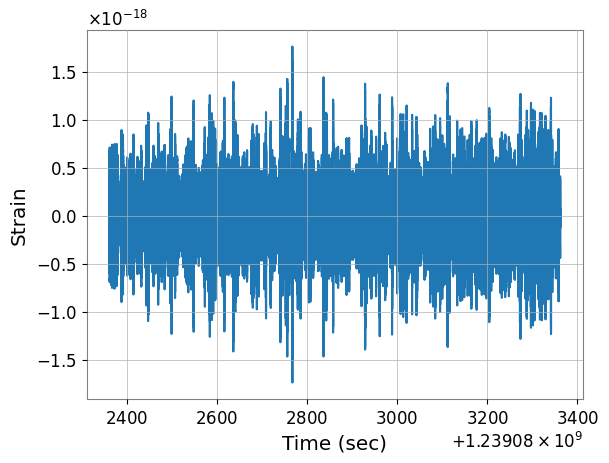

In [144]:
%matplotlib inline
import pylab
import numpy as np
import pycbc
from pycbc.types import TimeSeries
import matplotlib.pyplot as plt

# Load the data and create a TimeSeries object
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
strain = d[:, 1]
dt = time[1] - time[0]
data = TimeSeries(strain, delta_t=dt)

# Plot the data
plt.plot(time, data)
plt.xlabel('Time (sec)')
plt.ylabel('Strain')
plt.show()


In [145]:
# Calculate the sampling interval
dt = np.mean(np.diff(time))

# Calculate the sampling rate
sampling_rate3 = 1 / dt

print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 4096.0 Hz


Calculating the power spectral density (PSD) of the data using a segment duration of 4 seconds and ploting it on a logarithmic scale.

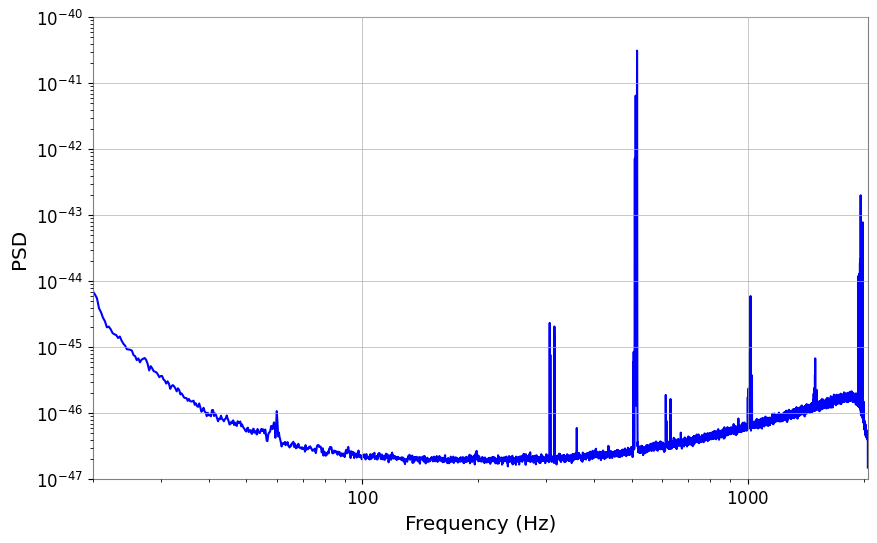

In [146]:
psd = data.psd(segment_duration=4)
nyqf=sampling_rate3/2
# Plot the PSD on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(psd.sample_frequencies, psd, color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim(20, nyqf)
plt.ylim(1e-47,1e-40)
plt.show()

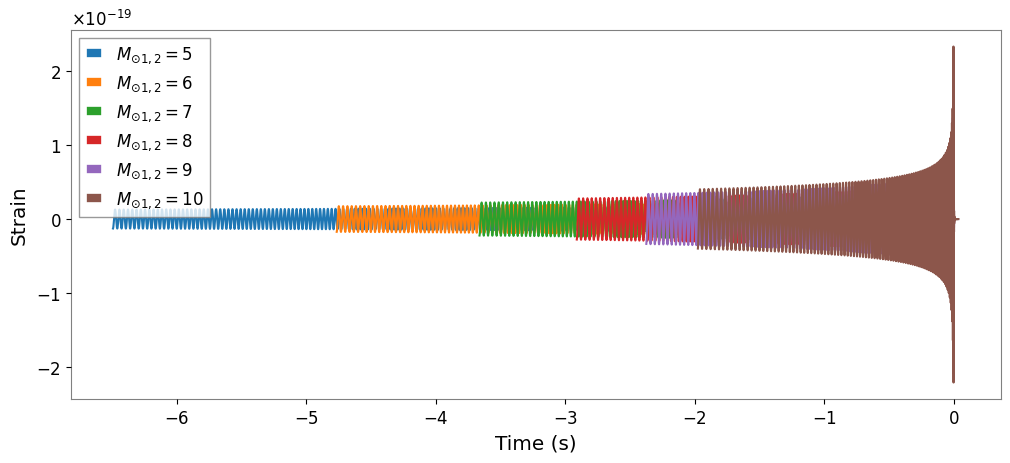

In [147]:
# Component mass of each binary component. We'll simplify here and assume that each
# component of the binary has the same mass. Again, units are in solar masses.
pylab.figure(figsize=pylab.figaspect(0.4))
for m in [5, 6, 7, 8, 9, 10]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

Conditioning the data

In [181]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = data.crop(2, 2)
psdc = conditioned.psd(4)
psdc = interpolate(psd, conditioned.delta_f)
psdc = inverse_spectrum_truncation(psdc, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

Creating a template for the waveform for mass range between 5 and 10

In [235]:
for m in [5, 6, 7, 8, 9, 10]:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=1.0/4096,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

This part is for matched filtering between the created template and conditioned data, using the provided power spectral density (PSD) and a low-frequency cutoff of 20 Hz. It then plots the resulting signal-to-noise ratio (SNR) time series and identifies the peak SNR value along with its corresponding time index. However as we can see there is no peak in the signal therefore we can not detect if there is a gravitational wave.

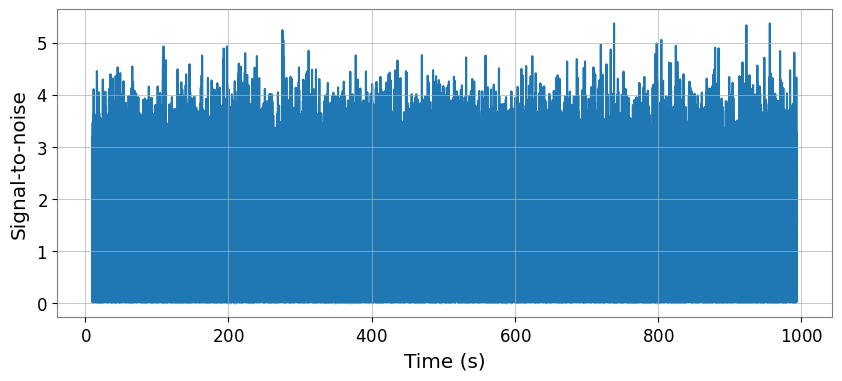

We found a signal at 956.0270996090002s with SNR 5.369554015264822


In [154]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

Since we assume a treshold on Matched filter SNR of 8 to claim a gravitational wave we can say that the signal we have provided as the SNR as the matched filter SNR for the data is 5,3695

2. **Whiten the above data using its noise PSD. You can use PyCBC based function of the
Welch method to estimate the PSD. Construct a histogram of the whitened data and
show that the whiten data follows a Gaussian distribution with zero mean.**

For whitening the data I am using code provided from the tutorial. The code includes cutting of the edges of the PSD array that can cause issues. Additionally the code calculates the whitened data by dividing the conditioned data, converted to frequency series, by the square root of the PSD (psdc). This operation effectively scales the conditioned data by the inverse of the noise amplitude at each frequency bin, resulting in whitened data where the noise is approximately constant across all frequencies. At the end another snip is performed to remove edge effects

In [199]:
from pycbc.types import TimeSeries

psdc[0]=psdc[1]
psdc[len(psdc)-1]=psdc[len(psdc)-2]
white_data = (conditioned.to_frequencyseries() / psdc**0.5).to_timeseries()
white_data=white_data.crop(4,4)

In this cell I am plotting the whit_data in a histogram centered at zero. As we can see on the graph it follows a gaussian distribution shape.

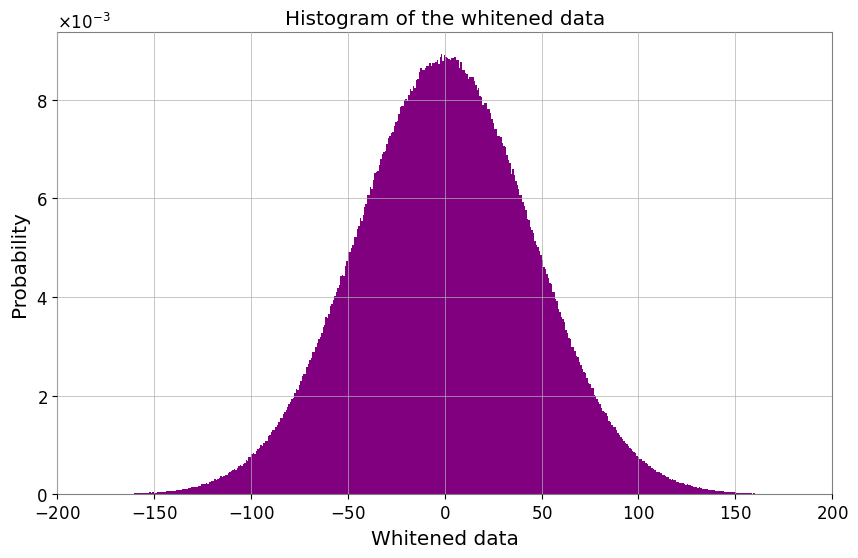

In [200]:
plt.figure(figsize=(10, 6))
plt.hist(white_data, bins="auto", density=True, color='purple', label='Whitened Data')
plt.xlim(-200,200)
plt.title("Histogram of the whitened data")
plt.xlabel("Whitened data")
plt.ylabel("Probability")
plt.show()

**3.In gravitational wave data analysis, we consider that the noise is stationary Gaussian.
But in reality, the stationary assumption does not hold. Can you think of a test to
show that the stationarity does not hold?**

For this part was decided to plot the histograms of chunk means and chunk deviations and chunk standard deviations in order to complete a hypothesis test in conjunction with histograms. By visually comparing means and standard deviations across different segments of the data and using hypothesis tests for statistical validation, the approach suggests that gravitational waves may not be stationary.  
**Resource 2 was used in order to come up with a test.**

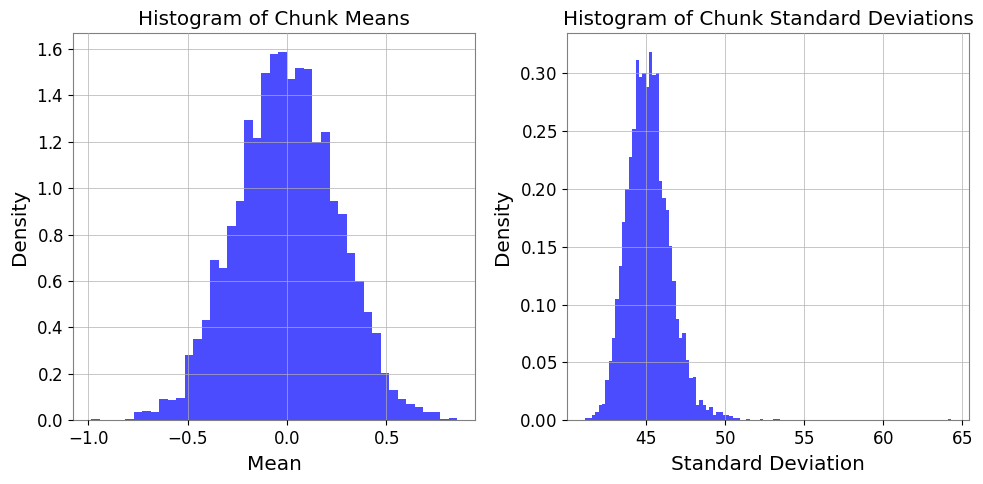

In [209]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Divide data into chunks (adjust chunk size as needed)
chunk_size = 1000
num_chunks = len(white_data) // chunk_size
chunks = np.array_split(white_data, num_chunks)

# Calculate mean and standard deviation for each chunk
chunk_means = [np.mean(chunk) for chunk in chunks]
chunk_std_devs = [np.std(chunk) for chunk in chunks]

# Plot histograms of mean and standard deviation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(chunk_means, bins='auto', density=True, color='b', alpha=0.7)
plt.title('Histogram of Chunk Means')
plt.xlabel('Mean')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(chunk_std_devs, bins='auto', density=True, color='b', alpha=0.7)
plt.title('Histogram of Chunk Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

The histograms generated from this code reveal noticeable differences between chunks, indicating variations in the statistical properties of the data over different segments.

These differences in the histograms provide evidence against the assumption of stationarity in the data. They suggest that the statistical properties of the data, such as the mean and standard deviation, vary over time, therefore we can consider the gravitational waves to be non-stationary.

*Resources*
1. GW_Big data tutorial - PRA3024, Big Data in physcis
2. [Histograms](https://statisticsbyjim.com/basics/histograms/)